In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import textwrap
import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math

import pingouin as pg
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import sys
import os
sys.path.append(os.path.join(".."))

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

C:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
C:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
C:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
C:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
C:\Users\srandrad\Anaconda3\lib\

In [3]:
csv_file_name = os.path.join(os.path.dirname(os.getcwd()),'data','SAFECOM_data.csv')
df = pd.read_csv(csv_file_name)#pd.read_excel(csv_file_name,sheet_name='safecom-2011-present-NASA')
fire_missions = [mission for mission in list(df['Mission Type']) if type(mission) is str and 'fire' in mission.lower()]
df = df.loc[df['Mission Type'].isin(fire_missions)].reset_index(drop=True)
df['Year'] = [df.at[i,'Date'].split('/')[-1] for i in range(len(df))]
df['Day'] = [df.at[i,'Date'].split('/')[1] for i in range(len(df))]
df['Month'] = [df.at[i,'Date'].split('/')[0] for i in range(len(df))]
#df['Year'].value_counts()

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#NIFC based in boise
#idaho and wyoming are split in regions
def correct_regions(df):
    region_dict ={
        'Region 05 Pacific Southwest Region': ['5', 'California', 'Hawaii', 'Pacific West Regional Office','California State Office','R2-Southwest Regional Office', 'National Guard'],
        'Region 06 Pacific Northwest Region':['Oregon/Washington State Office', 'Washington', 'Oregon', 'Washington Office','R9-Washington Office',
                                             'PNW Research Station FIA','R1-Pacific Regional Office'],
        'Region 01 Northern Rockies Region':['Montana/Dakotas State Office', 'Montana'], 
        'Region 04 Intermountain Region':['Nevada State Office','DOI-OAS - Headquarters Boise', 'Intermountain Regional NPS Headquarters',
                                         'Utah','Utah State Office', 'Nevada', 'National Interagency Fire Center', 'DOI-OAS - Western Region Office',
                                         'DOI-OAS - Technical Services', 'DOI-OAS - Unmanned Aircraft System Office'],
        'Region 03 Southwest Region':['Southeast Region','Arizona State Office','Arizona','New Mexico','New Mexico State Office'],
        'Region 09 Eastern Area Region':['New Jersey', 'Pennsylvania', 'Minnesota','Pennsylvania','Midwest Regional NPS Headquarters','R3-Great Lakes - Big Rivers Regional Office',
                                        'Northeast Regional Office', 'DOI-OAS - Eastern Region Office','Northeastern Area, S&PF','Wisconsin','Eastern States Office','National Capitol Parks'],
        'Region 02 Rocky Mountain Region':['Colorado State Office', 'Colorado','R6-Mountain-Praire Regional Office', 'DMBM - Migratory Birds', 'Wyoming', 'South Dakota'], 
        'Region 08 Southern Area Region':['Gulf of Mexico Region','Texas','Oklahoma','North Carolina', 'South Carolina','Florida','R4-Southeast Regional Office', 'Tennessee'],
        'Region 10 Alaska Region': ['Alaska State Office','Alaska OCS Region', 'Alaska Regional Office', 'Alaska','DOI-OAS - Alaska Regional Office',
                                   'R7-Alaska Regional Office']

    }
    regions_corrected = []
    indices_to_drop = []
    for i in range(len(df)):
        current_region = df.iloc[i]['Region']
        correct_region = None
        for region in region_dict:
            if (region == current_region) or (current_region in region_dict[region]):
                correct_region = region
                break 
        if not correct_region:
            correct_region = current_region
        if correct_region in ['CAMP â€“ Campaign Against Marijuana Program', 'Commercial Aircraft Services', 'Aircraft Operations Center','National Capitol Parks', 'Department of Defense', 'National Guard']:
            indices_to_drop.append(i)
        if correct_region == 'Idaho':
            if df.iloc[i]['Location'] in ['Clear Creak Fire', 'garden valley', 'Idaho City', 'Idaho City Helibase (U98)','Ranft Fire']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 01 Northern Rockies Region'
        elif correct_region == 'Pacific Region':
            correct_region = 'Region 05 Pacific Southwest Region'
        elif correct_region == 'Idaho State Office':
            if df.iloc[i]['Location'] in ['Granite Creek Fire', '47.512775, -116.002886','Post Falls, ID']:
                correct_region = 'Region 01 Northern Rockies Region'
            else: 
                correct_region = 'Region 04 Intermountain Region'
        elif correct_region == 'Wyoming State Office':
            if df.iloc[i]['Location'] in ['Tokewanna Fire','Rock Springs Sweetwater County', 'Evanston, WY Airport']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 02 Rocky Mountain Region'
        regions_corrected.append(correct_region)

    df['region_corrected'] = regions_corrected
    df = df.drop(indices_to_drop, axis=0).reset_index(drop=True)
    return df

In [5]:
list_of_attributes = ['Narrative']#, 'corrective_public', 'notes']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'

file = os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022','preprocessed_data.csv')
safecom = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, list_of_attributes=list_of_attributes, combine_cols=False)
safecom.extract_preprocessed_data(file)
preprocessed_df = safecom.data_df
preprocessed_df['Year'] = [preprocessed_df.at[i,'Date'].split('/')[-1] for i in range(len(preprocessed_df))]
preprocessed_df['Day'] = [preprocessed_df.at[i,'Date'].split('/')[1] for i in range(len(preprocessed_df))]
preprocessed_df['Month'] = [preprocessed_df.at[i,'Date'].split('/')[0] for i in range(len(preprocessed_df))]

In [6]:
preprocessed_df = preprocessed_df.loc[ preprocessed_df['Year'].astype(int)<2021].reset_index(drop=True)

In [7]:
hazard_file = os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022', 'hazard_interpretation_SAFECOM_Final.xlsx')
results_file = os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022','lda_results.xlsx')

In [8]:
#hazard_info = pd.read_excel(hazard_file, sheet_name=['topic-focused'])

In [9]:
#remove ids from results file and preprocessed_df if the mission is non-fire
non_fire_missions = [mission for mission in list(preprocessed_df['Mission Type']) if type(mission) is str and 'non-fire' in mission.lower()]
ids_to_drop = preprocessed_df.loc[preprocessed_df['Mission Type'].isin(non_fire_missions)]['Tracking #'].tolist()
print(len(ids_to_drop))

1986


In [10]:
frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2,  ids_to_drop= ids_to_drop)

In [11]:
#_ = hazard_accuracy(docs, num=15, results_path=os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022'))

In [12]:
#frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Raw_Narrative', 'Year', "Tracking #", 'Narrative_reduced_BERT_topics')

In [13]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"No":0, "Yes":1}
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

In [14]:
def create_table(docs, frequency, preprocessed_df, id_field, categories, subcategories, hazards, time_field, accuracy_file):
    table = pd.DataFrame({"Category": categories, "Subcategory": subcategories, "Hazards": hazards})
    accuracy_df = pd.read_excel(accuracy_file, sheet_name=['Summary'])['Summary']
    time_period = preprocessed_df[time_field].unique()
    severities = {name:{str(time_p):[] for time_p in time_period} for name in hazards}
    rates = {name:{str(time_p):0 for time_p in time_period} for name in hazards}
    total_docs_per_year = preprocessed_df[time_field].value_counts()
    total_rates = {hazard:0 for hazard in hazards}
    total_hazard_freq = {hazard:0 for hazard in hazards}
    total_severities_hazard = {hazard:0 for hazard in hazards}
    total_docs = len(preprocessed_df)
    precision = []
    for hazard in hazards:
        hazard_precision = accuracy_df.loc[accuracy_df['Hazards']==hazard].reset_index(drop=True)['Accuracy'].tolist()[0]
        precision.append(round(hazard_precision,3))
        for year in docs[hazard]:
            year = str(year)
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['Persons Onboard'], doc_df.iloc[0]['Injuries'], doc_df.iloc[0]['Damages']))
            rates[hazard][year] = frequency[hazard][year]/total_docs_per_year[year]
            total_hazard_freq[hazard] += frequency[hazard][year]
        total_rates[hazard] = round(total_hazard_freq[hazard]/len(time_period), 3)
        total_severities_hazard[hazard] = round(np.average([sev for year in severities[hazard] for sev in severities[hazard][year]]),3)
    table["Frequency"] = [total_hazard_freq[hazard] for hazard in total_hazard_freq]
    table["Rate"] = [total_rates[hazard] for hazard in total_rates]
    table["Severity"] = [total_severities_hazard[hazard] for hazard in total_severities_hazard]
    table["Precision"] = precision
    return table, severities, rates
    

In [15]:
def get_categories_from_docs(docs, preprocessed_df, id_field, category_fields = ['Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention']):
    categories = {hazard: [] for hazard in docs}
    sub_categories = {hazard: [] for hazard in docs}
    for hazard in docs:
        ids = [id_ for year in docs[hazard] for id_ in docs[hazard][year]]
        hazard_df = preprocessed_df.loc[preprocessed_df[id_field].isin(ids)].reset_index(drop=True)
        #main category is the category with the most reports
        cat_counts = {}
        for cat in category_fields:
            cat_counts[cat] = len(hazard_df.loc[hazard_df[cat].notna()])
        main_category = max(cat_counts, key=cat_counts.get)
        categories[hazard] = main_category
        #subcategories are the most common value in that catgeory
        #subcats = hazard_df[main_category].value_counts()
        #print(subcats)
        if len(hazard_df[main_category].value_counts()) == 0:
            sub_categories[hazard] = ""
        else:
            sub_cats = hazard_df[main_category].tolist()
            sub_cats = [cat for sub_cat in sub_cats for cat in str(sub_cat).split(", ")]
            sub_cats =[cat for cat in sub_cats if cat != 'nan']
            sub_cat_series = pd.Series(sub_cats).dropna()
            #sub_cat_series = sub_cat_series.loc[sub_cat_series.notna()].reset_index(drop=True)
            #print(sub_cat_series.value_counts())
            sub_categories[hazard] = sub_cat_series.value_counts().idxmax(axis = 0)#hazard_df[main_category].value_counts().idxmax(axis = 0)#list(hazard_df[main_category].value_counts())
            #sub_categories[hazard] = hazard_df[main_category].value_counts().idxmax(axis = 0)
            #print(hazard_df[main_category].value_counts())
    return categories, sub_categories

In [16]:
hazards_to_drop = ['Runway Hazards', 'Runway Collisions', 'Refuel Truck Problems']
hazards = [hazard for hazard in frequency if hazard not in hazards_to_drop]
docs = {hazard:docs[hazard] for hazard in hazards}
categories, sub_categories = get_categories_from_docs(docs, preprocessed_df, "Tracking #")
categories = categories.values()
subcategories = sub_categories.values()
accuracy_file = os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022', 'hazard_extraction_accuracy_final.xlsx')
table, severities, rates = create_table(docs, frequency, preprocessed_df, "Tracking #", categories, subcategories, hazards, 'Year', accuracy_file)

In [17]:
table = table.sort_values(['Category', 'Subcategory'], axis=0).reset_index(drop=True)
df = table[['Category', 'Subcategory']]
ind = pd.MultiIndex.from_frame(df)
table.index = ind
table = table.drop(['Category', 'Subcategory'], axis=1)

In [18]:
table

Hazards  Frequency  \
Category    Subcategory                                                       
Airspace    Conflict                    Airspace Control Hazards         68   
            Intrusion                                  Intrusion        227   
Hazard      Communications             Jumper Operations Hazards         57   
            Communications          Helitorch Operations Failure         35   
            Communications                     Radio Malfunction         21   
            Other                          Cargo Letdown Failure        459   
            Other                                   Door Failure        479   
            Pilot Action                     Bucket Drop Failure       1063   
            Policy Deviation                             Medivac         41   
            Policy Deviation                Load Limits Exceeded         46   
            Policy Deviation                      Inadequate PPE         35   
            Policy Deviation       Personnel Duty Hours Exceeded         77   
            Weather                               Severe Weather        158   
Maintenance Airframe                         In-flight Collision         23   
            Caution Light     On-board Caution Light Illuminates        129   
            Chip Light                        Engine Malfunction        673   
            Electrical                      Avionics Malfunction        367   
            Engine                        Tanker Loading Failure         84   
            Fuel                         Fuel System Malfunction         42   
            Hydraulic                       Hydraulic Fluid Leak        258   
            Landing Gear                Landing Gear Malfunction        204   
            Oil                                  Oil Malfunction        194   
            Rotor (Main)                  Control Surface Damage        405   

                                Rate  Severity  Precision  
Category    Subcategory                                    
Airspace    Conflict           2.519     0.029      0.800  
            Intrusion          8.407     0.000      1.000  
Hazard      Communications     2.111     3.561      0.800  
            Communications     1.296     0.171      0.800  
            Communications     0.778     0.238      0.933  
            Other             17.000     0.229      0.800  
            Other             17.741     0.706      0.867  
            Pilot Action      39.370     0.464      0.733  
            Policy Deviation   1.519     1.512      1.000  
            Policy Deviation   1.704     0.065      0.867  
            Policy Deviation   1.296     0.000      0.800  
            Policy Deviation   2.852     0.026      0.800  
            Weather            5.852     0.848      0.800  
Maintenance Airframe           0.852     0.783      0.800  
            Caution Light      4.778     0.054      1.000  
            Chip Light        24.926     0.048      0.933  
            Electrical        13.593     0.125      0.933  
            Engine             3.111     0.214      0.733  
            Fuel               1.556     0.048      0.733  
            Hydraulic          9.556     0.147      0.933  
            Landing Gear       7.556     0.181      0.933  
            Oil                7.185     0.000      1.000  
            Rotor (Main)      15.000     0.551      0.800

In [19]:
table.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'SAFECOM_hazards.csv'))

In [20]:
average_precision = np.average(table['Precision'].tolist())
std_precision = np.std(table['Precision'].tolist())
print(average_precision, std_precision)

0.8607826086956523 0.08990717750606873


In [21]:
docs_per_hazard = {hazard:[doc for year in docs[hazard] for doc in docs[hazard][year]] for hazard in docs}

In [22]:
hazards = []; tracking_num = []

In [23]:
for hazard in docs_per_hazard:
    for num in docs_per_hazard[hazard]:
        hazards.append(hazard)
        tracking_num.append(num)
hazard_docs_df = pd.DataFrame({"Hazard":hazards,
                              "Tracking #": tracking_num})

In [24]:
hazard_docs_df.to_csv(os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022','hazard_docs.csv'))

In [25]:
# fuel_leak_ids = [i for year in docs['Fuel Leak'] for i in docs['Fuel Leak'][year]]
# fuel_ids = [i for year in docs['Fuel System Malfunction'] for i in docs['Fuel System Malfunction'][year]]
# fuel_ids_total = fuel_ids + fuel_leak_ids
# fuel_df = pd.read_csv("fuel.csv")
# non_identified_df = fuel_df.loc[(~fuel_df['Tracking #'].isin(fuel_ids_total)) & (~fuel_df['Tracking #'].isin(ids_to_drop))].reset_index(drop=True)
# topics = [[] for i in range(len(non_identified_df))]
# results = pd.read_excel(results_file, sheet_name=['Narrative'])['Narrative']
# non_ids = [id_ for id_ in non_identified_df['Tracking #'].tolist()]
# for i in range(len(results)):
#     doc_ids = [i.strip("'") for i in results.iloc[i]["documents"].strip("[]").split(", ")]
#     topic = results.iloc[i]['topic number']
#     if any(i in doc_ids for i in non_ids):
#         ids = [i  for i in non_ids if i in doc_ids]
#         ids_ind =[non_ids.index(id_) for id_ in ids]
#         for ind in ids_ind:
#             topics[ind].append(topic)
# non_identified_df['Topics'] = topics
# non_identified_df.to_csv("fuel_unidentified.csv")

In [26]:
#print(table.to_latex())

In [27]:
hazards_for_analysis = ['Hydraulic Fluid Leak', 'Intrusion', 'Bucket Drop Failure','Radio Malfunction',
                       'Jumper Operations Hazards', 'Tanker Loading Failure', 'Helitorch Operations Failure',
                       'Cargo Letdown Failure', 'Severe Weather']

In [28]:
#updat: frequency, docs, severities, rates, hazards
frequency = {hazard: frequency[hazard] for hazard in hazards_for_analysis}
docs = {hazard: docs[hazard] for hazard in hazards_for_analysis}
severities = {hazard: severities[hazard] for hazard in hazards_for_analysis}
rates = {hazard: rates[hazard] for hazard in hazards_for_analysis}
hazards = hazards_for_analysis

In [29]:
def plot_metric_time_series(metric_data, metric_name, line_styles=[], markers=[], title="", time_name="Year", scaled=False, xtick_freq=5, show_std=True, save=False):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    #scaled -> scaled the averages, how to scale stddev?
    if scaled: metric_data = {hazard: minmax_scale(metric_data[hazard]) for hazard in metric_data}
    averages = {hazard: [np.average(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    stddevs = {hazard: [np.std(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    colors = cm.tab10(np.linspace(0, 1, len(averages)))
    plt.figure()
    plt.title(title, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    plt.yscale('symlog')
    i=0
    for hazard in averages:
        if show_std == True:
            plt.errorbar(time_vals, averages[hazard], yerr=stddevs[hazard], color=colors[i], marker=markers[i], linestyle=line_styles[i], label=hazard, capsize=5, markeredgewidth=1)
        else:
            plt.plot(time_vals, averages[hazard], color=colors[i], marker=markers[i], linestyle=line_styles[i], label=hazard)
        i += 1
    plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.xticks(np.arange(1, int(len(time_vals))+1, xtick_freq),rotation=45)
    plt.tick_params(labelsize=16)
    plt.savefig('SAFECOM_hazard_'+metric_name+'.pdf', bbox_inches="tight") 
    plt.show()

def plot_metric_averages(metric_data, metric_name, show_std=True, title="", save=False, legend=True):
    avg = {hazard: np.average([m for year in metric_data[hazard] for m in metric_data[hazard][year]]) for hazard in metric_data}
    stddev = {hazard: np.std([m for year in metric_data[hazard] for m in metric_data[hazard][year]]) for hazard in metric_data}
    x_pos = np.arange(len(metric_data))
    fig, ax = plt.subplots()
    colors = cm.tab10(np.linspace(0, 1, len(metric_data)))
    labels = [key for key in metric_data.keys()]
    ax.bar(x_pos, avg.values(), yerr=stddev.values(), align='center', ecolor='black', capsize=10, color=colors)
    plt.xlabel("Hazard", fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    plt.title(title, fontsize=16)
    ax.yaxis.grid(True)
    plt.tick_params(labelsize=14)
    if legend == True:
        ax.set_xticklabels([])
        handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
        plt.legend(handles, labels, bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    elif legend == False:
        labels = list(metric_data.keys())
        mean_length = np.mean([len(i) for i in labels])
        labels = ["\n".join(textwrap.wrap(i,mean_length)) for i in labels]
        ax.set_xticks(np.asarray([i for i in range(len(metric_data))]))
        ax.set_xticklabels(labels,rotation=45,ha="right",rotation_mode='anchor')
    plt.savefig('SAFECOM_hazard_bar_'+metric_name+'.pdf', bbox_inches="tight") 
    plt.show()

In [30]:
def plot_frequency_time_series(metric_data, metric_name='Frequency', line_styles=[], markers=[], title="", time_name="Year", xtick_freq=5, scale=True, save=False):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    frequencies = {hazard: [metric_data[hazard][year] for year in time_vals] for hazard in metric_data}
    if scale==True:
        hazard_freqs_scaled = {hazard: minmax_scale(frequencies[hazard]) for hazard in frequencies}
        y_label = "Total Scaled "+metric_name
    else:
        hazard_freqs_scaled = frequencies
        y_label = metric_name
    colors = cm.tab10(np.linspace(0, 1, len(frequencies)))
    plt.figure()
    plt.ylabel(y_label, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.title(title, fontsize=16)
    i = 0
    for hazard in hazard_freqs_scaled:
        plt.plot(time_vals, hazard_freqs_scaled[hazard], color=colors[i], label=hazard, marker=markers[i], linestyle=line_styles[i])
        i += 1
    #plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.xticks(np.arange(1, int(len(time_vals))+1, xtick_freq),rotation=45)
    plt.tick_params(labelsize=16)
    plt.savefig('SAFECOM_hazard_'+metric_name+'.pdf', bbox_inches="tight") 
    plt.show()

C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


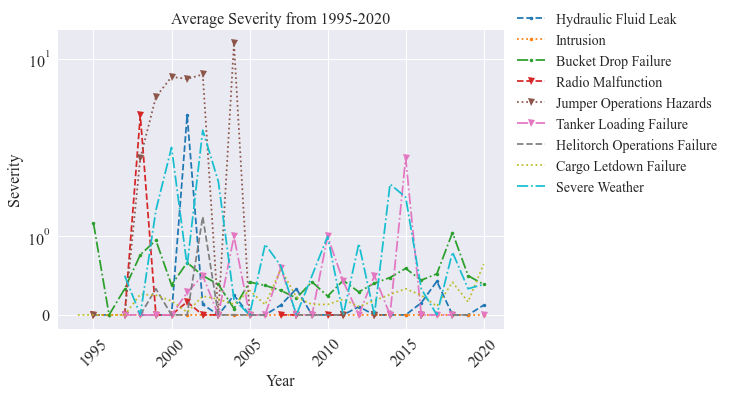

In [31]:
markers = ['.','.','.', 'v', 'v','v', 'x', 'x', 'x']
line_styles = ['--', ':','-.','--', ':','-.','--', ':','-.']

plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", time_name='Year', show_std=False, save=True)
#plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", time_name='Year', show_std=True, save=False)

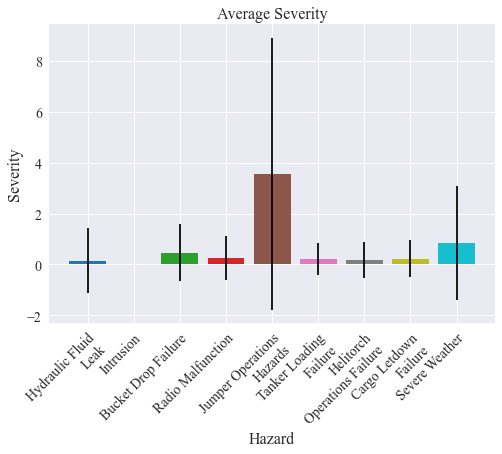

In [32]:
plot_metric_averages(metric_data=severities, metric_name="Severity", show_std=True, title="Average Severity", save=True, legend=False)

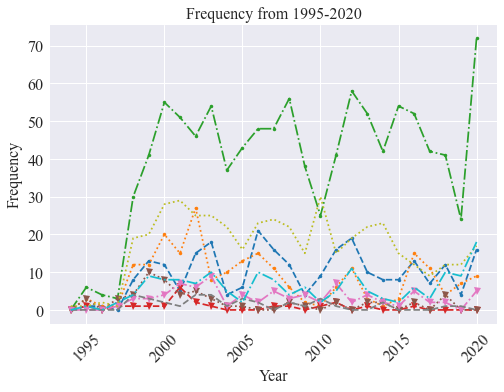

In [33]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 1995-2020", time_name="Year", scale=False)

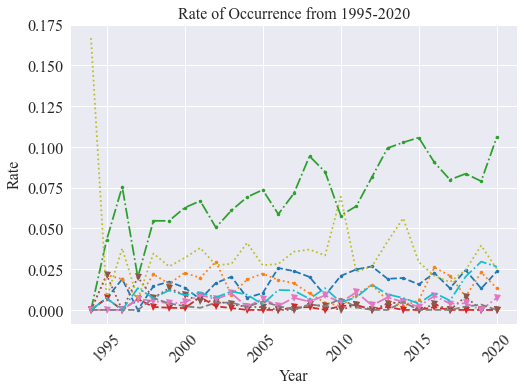

In [34]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 1995-2020", time_name="Year", scale=False, save=True)

# Pie Charts

In [35]:
def make_pie_chart(docs, data, predictor, hazards, id_field, predictor_label=None, save=True):
    if not predictor_label: predictor_label=predictor
    num_rows = int(np.ceil(len(hazards)/3))
    extra_axes = len(hazards)%3
    fig, axes = plt.subplots(num_rows, 3, figsize=(17,9))
    if extra_axes>0:
        for x in range(1,extra_axes):
            fig.delaxes(axes[num_rows-1][3-x])
    #set up lables, colors dict
    total_docs_with_hazards = [doc for hazard in hazards for year in docs[hazard] for doc in docs[hazard][year] ]
    labels = data.loc[data[id_field].isin(total_docs_with_hazards)][predictor].value_counts().index.sort_values()
    colors = cm.coolwarm(np.linspace(0, 1, len(labels)))
    for ax, hazard in zip(axes.flatten(), hazards):
        total_docs = [doc for year in docs[hazard] for doc in docs[hazard][year]]
        hazard_data = data.loc[data[id_field].isin(total_docs)].reset_index(drop=True)
        #label = hazard_data[predictor].value_counts().index.sort_values()
        #print(label)
        val_counts = hazard_data[predictor].value_counts()
        values = [val_counts[val] if val in val_counts else 0 for val in labels]
        #colors = cm.coolwarm(np.linspace(0, 1, len(label)))
        _, _, autopct = ax.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 12},labeldistance=None, pctdistance=1.2)
        for txt in autopct:
            if float(txt.get_text().strip("%"))<3.0:
                txt.set_visible(False)
                
        ax.set_title(hazard+" per "+predictor_label, fontdict={'fontsize': 14})
    axes[0,0].legend(bbox_to_anchor=(-0.2, 1),fontsize=14)
    plt.savefig('SAFECOM_hazard_'+predictor+'.pdf', bbox_inches="tight") 
    plt.show()

In [36]:
correct_regions(preprocessed_df)

,Agency,Region,Location,Date,Date Submitted,Tracking #,Mission Type,Persons Onboard,Departure Point,Destination,...,UAS,Accident,Airspace,Maintenance,Mishap Prevention,Raw_Narrative,Year,Day,Month,region_corrected
0,Bureau of Land Management (BLM),Alaska State Office,Fairbanks,05/10/1995,NaN,95-0002,"Fire, Smokejumper",1.0,Fairbanks,NaN,...,NaN,NaN,Intrusion,NaN,NaN,On a practice parachute jump a single engine a...,1995,10,05,Region 10 Alaska Region
1,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/10/1995,NaN,95-0003,"Fire, Smokejumper",4.0,Birch Hill,NaN,...,NaN,NaN,Intrusion,NaN,NaN,NXXXXX 5-10-95 A small airplane flew thr...,1995,10,05,Region 10 Alaska Region
2,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/09/1995,NaN,95-0004,"Fire, Air Attack",2.0,Fort Wainwright,NaN,...,NaN,NaN,NaN,Electrical,NaN,"After takeoff from Ft. Wainwight, left generat...",1995,09,05,Region 10 Alaska Region
3,Bureau of Land Management (BLM),California State Office,BFL,07/28/1995,NaN,95-0006,"Fire, Air Attack",2.0,BFL CA.,NaN,...,NaN,NaN,NaN,Hydraulic,NaN,Firewall fitting cracked - leaking hydraulic f...,1995,28,07,Region 05 Pacific Southwest Region
4,Bureau of Land Management (BLM),Alaska State Office,6 Mi East of FBK,07/16/1995,NaN,95-0007,Ferry/Repositioning Flight (Non-Fire),2.0,FBK,BOI,...,NaN,NaN,NaN,NaN,NaN,I have debated with myself if I should file a ...,1995,16,07,Region 10 Alaska Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14534,State,California,McClellan Reload Base,12/20/2020,NaN,21-0151,"Fire, Leadplane",0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"Prior to pilots' preflight, ATS noticed eviden...",2020,20,12,Region 05 Pacific Southwest Region
14535,State,California,Hemet Airport,12/24/2020,NaN,21-0152,"Fire, Retardant Drop (Airtanker)",1.0,KHMT,KRNM,...,NaN,NaN,NaN,NaN,NaN,While fueling at Ramona AAB after 2.5 hour fue...,2020,24,12,Region 05 Pacific Southwest Region
14536,State,California,Camp Pendleton,12/24/2020,NaN,21-0154,"Fire, Water Drop (Helicopter Fixed-Tank)",3.0,KCRQ,Creek Fire Camp Pendleton,...,NaN,NaN,NaN,NaN,NaN,While engaged in a water dropping mission HT-7...,2020,24,12,Region 05 Pacific Southwest Region
14537,U.S. Geological Survey (USGS),NaN,Hawaii Volcanoes National Park,12/29/2020,NaN,21-0155,Survey/Observation (Non-Fire),0.0,"Crater Rim Dr., west of Kilauea Caldera","Crater Rim Dr., west of Kilauea Caldera",...,"UAS, Fleet Operation, Loss of Link",NaN,NaN,NaN,NaN,A team of two pilots began flying on Crater Ri...,2020,29,12,NaN


In [37]:
print(preprocessed_df.loc[preprocessed_df['region_corrected']=='National Guard'])

Empty DataFrame
Columns: [Agency, Region, Location, Date, Date Submitted, Tracking #, Mission Type, Persons Onboard, Departure Point, Destination, Special Use, Damages, Injuries, Hazardous Materials, Other Mission Type, Type, Manufacturer, Model, Narrative, Hazard, UAS, Accident, Airspace, Maintenance, Mishap Prevention, Raw_Narrative, Year, Day, Month, region_corrected]
Index: []

[0 rows x 30 columns]


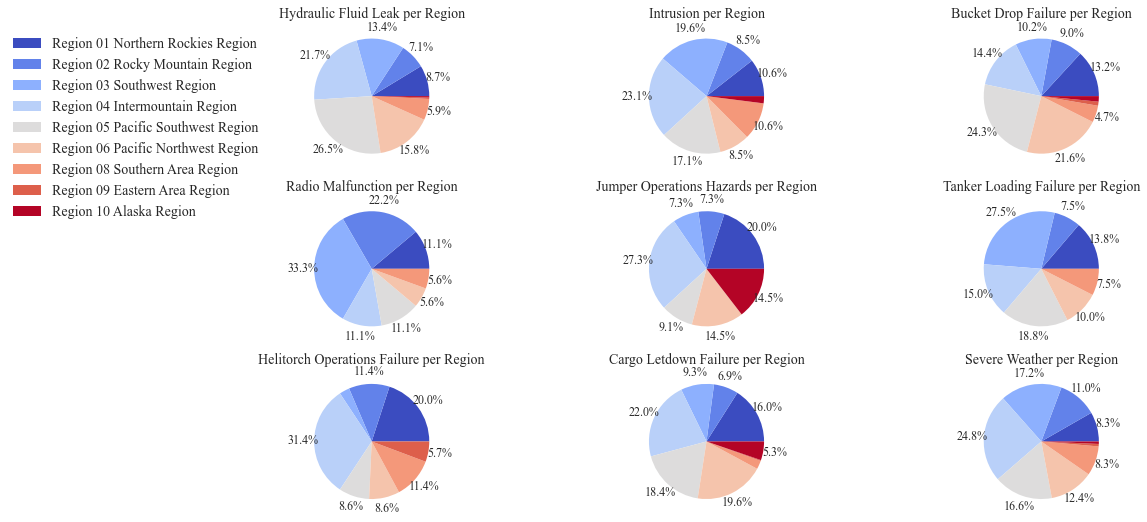

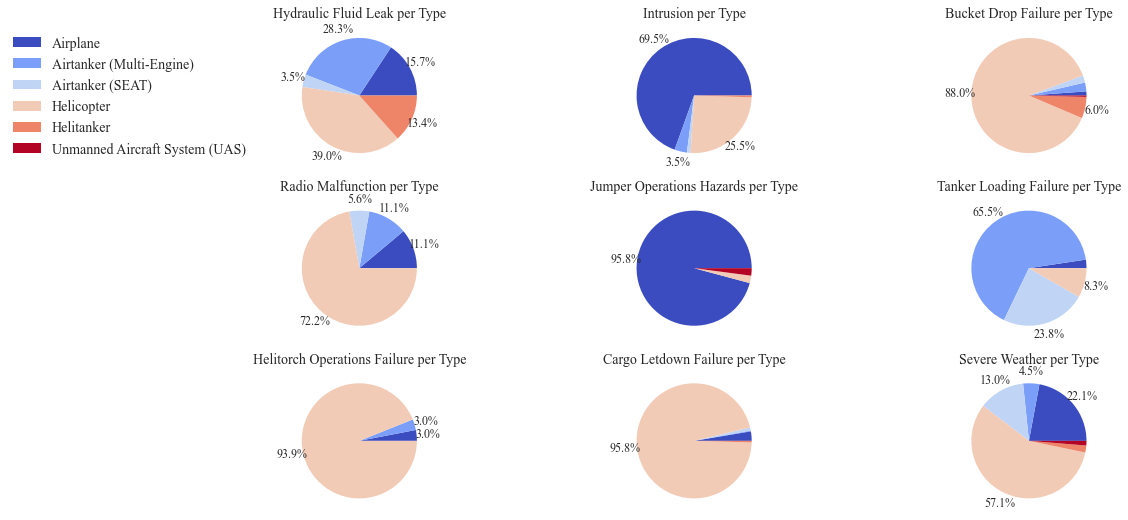

In [38]:
predictors = ['region_corrected', 'Type']#, 'Manufacturer', 'Model','Mission Type']
for predictor in predictors:
    if predictor == 'region_corrected': 
        predictor_label='Region'
    else:
        predictor_label = None
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'Tracking #', predictor_label)

# Chi-Squared Analysis

In [39]:
#add hazard values to preprocessed_df
hazards_per_doc = {doc:[] for doc in preprocessed_df['Tracking #']}
hazards_col = ["None" for i in range(len(preprocessed_df))]
hazards_for_df = {hazard:[0 for i in range(len(preprocessed_df))] for hazard in docs}
for hazard in docs:
    for year in docs[hazard]:
        for doc in docs[hazard][year]:
            hazards_for_df[hazard][preprocessed_df.index[preprocessed_df['Tracking #']==doc].tolist()[0]] = 1
            if hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] =="None":
                hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] = hazard
            else:
                hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] += hazard
    preprocessed_df[hazard] = hazards_for_df[hazard]
preprocessed_df['hazard'] = hazards_col
#add severities
severities = []
for i in range(len(preprocessed_df)):
    severities.append(safecom_severity(preprocessed_df.iloc[i]['Persons Onboard'], preprocessed_df.iloc[i]['Injuries'], preprocessed_df.iloc[i]['Damages']))
preprocessed_df["severity"] = severities

In [40]:
count_dfs = {}
pred_dict = {'region_corrected':'Region', 'Type': "Aircraft Type", 'Agency':'Agency'}
stat_vals = {(pred_dict[pred],val): [] for pred in predictors for val in ["chi-squared", "p-val"]}
for predictor in predictors:
    vals = []
    hazard_vals = []
    pred_vals = [val for val in preprocessed_df[predictor].value_counts().index]
    diff_observed_expected = {pred_val:[] for pred_val in pred_vals}
    for hazard in hazards:
        expected, observed, stats = pg.chi2_independence(preprocessed_df, x=predictor,y=hazard)
        stat_vals[(pred_dict[predictor], "p-val")].append((stats.iloc[0]['pval'].round(3)))
        stat_vals[(pred_dict[predictor], "chi-squared")].append((stats.iloc[0]['chi2'].round(3)))
        for i in range(len(expected)):
            pred_val = expected.index[i]
            diff_observed_expected[pred_val].append(observed.iloc[i][0] - expected.iloc[i][0])
            diff_observed_expected[pred_val].append(observed.iloc[i][1] - expected.iloc[i][1])
    iterables = [hazards, [0,1]]
    index = pd.MultiIndex.from_product(iterables, names=["Hazard", "Present"])
    pred_df = pd.DataFrame(diff_observed_expected, index=index)
    count_dfs[predictor] = pred_df
iterables = [[pred_dict[pred] for pred in predictors], ["p-val", "chi-squared"]]
index = pd.MultiIndex.from_product(iterables, names=["Predictor", "Measure"])
stats_df = pd.DataFrame(stat_vals, index=hazards, columns=index)

C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


In [41]:
stats_df

Predictor                    Region             Aircraft Type            
Measure                       p-val chi-squared         p-val chi-squared
Hydraulic Fluid Leak          0.006      30.945         0.000     148.635
Intrusion                     0.003      32.756         0.000     223.527
Bucket Drop Failure           0.000     119.648         0.000     620.379
Radio Malfunction             0.389      14.850         0.670       3.194
Jumper Operations Hazards     0.066      22.634         0.000     135.347
Tanker Loading Failure        0.028      25.735         0.000     309.883
Helitorch Operations Failure  0.099      21.099         0.001      21.108
Cargo Letdown Failure         0.000      55.829         0.000     326.437
Severe Weather                0.095      21.282         0.000      33.552

In [42]:
#print(stats_df.to_latex())

In [43]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                -16.527291   
                             1                                 16.527291   
Intrusion                    0                                  5.699878   
                             1                                 -5.699878   
Bucket Drop Failure          0                                -42.089038   
                             1                                 42.089038   
Radio Malfunction            0                                  1.590944   
                             1                                 -1.590944   
Jumper Operations Hazards    0                                  5.972328   
                             1                                 -5.972328   
Tanker Loading Failure       0                                  0.959750   
                             1                                 -0.959750   
Helitorch Operations Failure 0                                  3.982391   
                             1                                 -3.982391   
Cargo Letdown Failure        0                                  6.589190   
                             1                                 -6.589190   
Severe Weather               0                                  4.927047   
                             1                                 -4.927047   

                                      Region 04 Intermountain Region  \
Hazard                       Present                                   
Hydraulic Fluid Leak         0                            -11.836865   
                             1                             11.836865   
Intrusion                    0                            -12.049550   
                             1                             12.049550   
Bucket Drop Failure          0                             25.828327   
                             1                            -25.828327   
Radio Malfunction            0                              1.070895   
                             1                             -1.070895   
Jumper Operations Hazards    0                             -5.616710   
                             1                              5.616710   
Tanker Loading Failure       0                              1.648422   
                             1                             -1.648422   
Helitorch Operations Failure 0                             -5.028815   
                             1                              5.028815   
Cargo Letdown Failure        0                            -20.516390   
                             1                             20.516390   
Severe Weather               0                            -11.262235   
                             1                             11.262235   

                                      Region 06 Pacific Northwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                 -1.195609   
                             1                                  1.195609   
Intrusion                    0                                 13.522031   
                             1                                -13.522031   
Bucket Drop Failure          0                                -60.917518   
                             1                                 60.917518   
Radio Malfunction            0                                  1.760787   
                             1                                 -1.760787   
Jumper Operations Hazards    0                                  0.435737   
                             1                                 -0.435737   
Tanker Loading Failure       0                                  4.270163   
                             1                                 -4.270163   
Helitorch Op

Helicopter    Airplane  \
Hazard                       Present                           
Hydraulic Fluid Leak         0         38.761797   22.303245   
                             1        -38.761797  -22.303245   
Intrusion                    0         57.473856  -89.942327   
                             1        -57.473856   89.942327   
Bucket Drop Failure          0       -353.139365  244.816919   
                             1        353.139365 -244.816919   
Radio Malfunction            0         -3.237353    2.415191   
                             1          3.237353   -2.415191   
Jumper Operations Hazards    0         25.033725  -34.226158   
                             1        -25.033725   34.226158   
Tanker Loading Failure       0         38.559019   18.604223   
                             1        -38.559019  -18.604223   
Helitorch Operations Failure 0        -13.101814    7.094516   
                             1         13.101814   -7.094516   
Cargo Letdown Failure        0       -188.306717   99.115630   
                             1        188.306717  -99.115630   
Severe Weather               0         -4.475131    3.774408   
                             1          4.475131   -3.774408   

                                      Airtanker (Multi-Engine)  \
Hazard                       Present                             
Hydraulic Fluid Leak         0                      -40.308488   
                             1                       40.308488   
Intrusion                    0                       17.953946   
                             1                      -17.953946   
Bucket Drop Failure          0                      104.633910   
                             1                     -104.633910   
Radio Malfunction            0                        0.245855   
                             1                       -0.245855   
Jumper Operations Hazards    0                        5.988947   
                             1                       -5.988947   
Tanker Loading Failure       0                      -44.519342   
                             1                       44.519342   
Helitorch Operations Failure 0                        3.117401   
                             1                       -3.117401   
Cargo Letdown Failure        0                       55.520689   
                             1                      -55.520689   
Severe Weather               0                       12.214539   
                             1                      -12.214539   

                                      Airtanker (SEAT)  Helitanker  \
Hazard                       Present                                 
Hydraulic Fluid Leak         0                2.841576  -25.289783   
                             1               -2.841576   25.289783   
Intrusion                    0                7.324075    5.858438   
                             1               -7.324075   -5.858438   
Bucket Drop Failure          0               27.811535  -27.096075   
                             1              -27.811535   27.096075   
Radio Malfunction            0               -0.160833    0.617259   
                             1                0.160833   -0.617259   
Jumper Operations Hazards    0                2.237778    1.646025   
                             1               -2.237778   -1.646025   
Tanker Loading Failure       0              -16.083888    2.880544   
                             1               16.083888   -2.880544   
Helitorch Operations Failure 0                1.538472    1.131642   
                             1               -1.538472   -1.131642   
Cargo Letdown Failure        0               17.119031   13.534363   
                             1              -17.119031  -13.534363   
Severe Weather               0              -12.820462    2.280998   
                             1               12.820462   -2.280998   

                                   

# ANOVA 

In [44]:
severities_dict = {hazard:[] for hazard in hazards}
AOV_df = {'hazard':[], 'severity':[]}
for hazard in hazards:
    hazard_df = preprocessed_df.loc[preprocessed_df[hazard] == 1]
    sevs = hazard_df['severity'].tolist()
    severities_dict[hazard] = sevs
    for sev in sevs:
        AOV_df['hazard'].append(hazard)
        AOV_df['severity'].append(sev)
AOV_df = pd.DataFrame(AOV_df)

In [45]:
anovas = []
for hazard in hazards:
    aov = pg.welch_anova(dv='severity', between=hazard, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Hydraulic Fluid Leak,1,262.136,0.635,0.426,0.000
0,Intrusion,1,14315.000,690.648,0.000,0.001
0,Bucket Drop Failure,1,1184.473,59.189,0.000,0.005
0,Radio Malfunction,1,20.069,0.020,0.889,0.000
0,Jumper Operations Hazards,1,56.012,22.184,0.000,0.047
0,Tanker Loading Failure,1,85.354,0.003,0.958,0.000
0,Helitorch Operations Failure,1,34.308,0.108,0.744,0.000
0,Cargo Letdown Failure,1,515.343,0.296,0.586,0.000
0,Severe Weather,1,157.598,12.814,0.000,0.005


In [46]:
aov = pg.welch_anova(dv='severity', between='hazard', data=AOV_df).round(3)

In [47]:
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,hazard,8,217.328,35.677,0.0,0.13


In [48]:
print(aov.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  Source &  ddof1 &    ddof2 &       F &  p-unc &   np2 \\
\midrule
0 &  hazard &      8 &  217.328 &  35.677 &    0.0 &  0.13 \\
\bottomrule
\end{tabular}



In [49]:
post_hoc = pg.pairwise_gameshowell(dv='severity', between='hazard',  data=AOV_df).round(3)

In [50]:
post_hoc = post_hoc.loc[post_hoc['pval']<0.05].reset_index(drop=True)

In [51]:
post_hoc = post_hoc[['A', 'B', 'df', 'T', 'pval', 'hedges']]
post_hoc.index = post_hoc['A']
post_hoc = post_hoc.drop(['A'], axis=1)
post_hoc

,B,df,T,pval,hedges
A,,,,,
Bucket Drop Failure,Cargo Letdown Failure,1316.583,4.900,0.000,0.274
Bucket Drop Failure,Hydraulic Fluid Leak,357.195,3.611,0.010,0.250
Bucket Drop Failure,Intrusion,1062.000,13.430,0.000,0.981
Bucket Drop Failure,Jumper Operations Hazards,56.262,-4.332,0.002,-0.589
Bucket Drop Failure,Tanker Loading Failure,130.812,3.275,0.035,0.371
Cargo Letdown Failure,Intrusion,458.000,6.872,0.000,0.557
Cargo Letdown Failure,Jumper Operations Hazards,56.244,-4.661,0.001,-0.654
Cargo Letdown Failure,Severe Weather,167.875,-3.386,0.024,-0.312
Helitorch Operations Failure,Jumper Operations Hazards,59.099,-4.682,0.001,-0.997


In [52]:
print(post_hoc.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &                          B &        df &       T &   pval &  hedges \\
A                            &                            &           &         &        &         \\
\midrule
Bucket Drop Failure          &      Cargo Letdown Failure &  1316.583 &   4.900 &  0.000 &   0.274 \\
Bucket Drop Failure          &       Hydraulic Fluid Leak &   357.195 &   3.611 &  0.010 &   0.250 \\
Bucket Drop Failure          &                  Intrusion &  1062.000 &  13.430 &  0.000 &   0.981 \\
Bucket Drop Failure          &  Jumper Operations Hazards &    56.262 &  -4.332 &  0.002 &  -0.589 \\
Bucket Drop Failure          &     Tanker Loading Failure &   130.812 &   3.275 &  0.035 &   0.371 \\
Cargo Letdown Failure        &                  Intrusion &   458.000 &   6.872 &  0.000 &   0.557 \\
Cargo Letdown Failure        &  Jumper Operations Hazards &    56.244 &  -4.661 &  0.001 &  -0.654 \\
Cargo Letdown Failure        &             Severe Weather &   167.

# Risk Matrix

In [7]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"

In [54]:
severities = table['Severity']
severities.index = table['Hazards']
severities = severities[hazards]
severities = severities.to_dict()
rates = table['Rate']
rates.index = table['Hazards']
rates = rates[hazards]
rates = rates.to_dict()

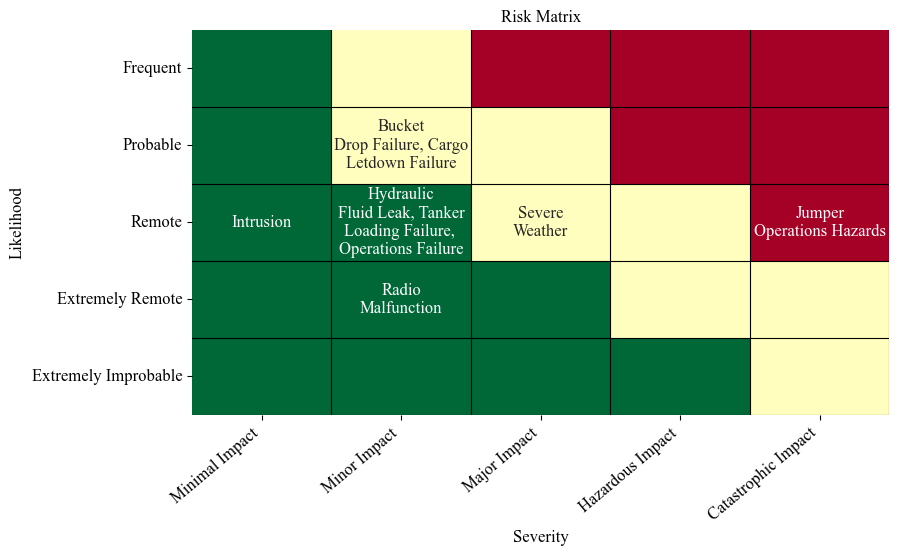

In [55]:
plot_risk_matrix(rates, severities, figsize=(9,5), save=True)

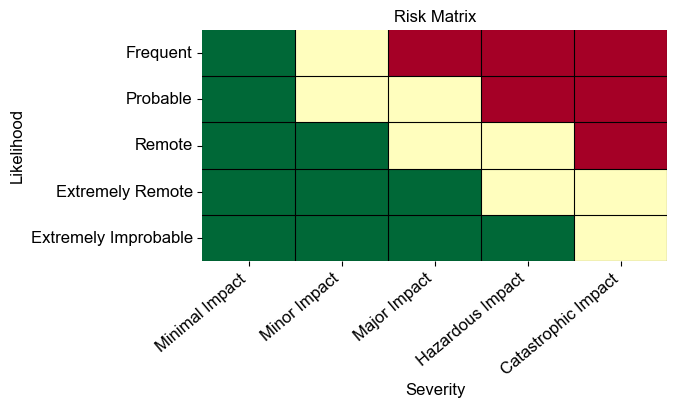

In [9]:
plot_risk_matrix(rates={}, severities={}, figsize=(6,3), save=True)